In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
print(tf.__version__)
#from talos.model.layers import hidden_layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv1D, Reshape
from keras.callbacks import ModelCheckpoint, History
from keras.activations import relu, elu, linear
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from tqdm import trange

plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12

/Users/jakobs/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jakobs/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jakobs/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jakobs/miniconda3/lib/python3.7/site-packages/tensorflow/python/frame

1.14.0


In [2]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

In [3]:
data_pd = pd.read_csv("../data/credit_card_cleaned.csv")
data = data_pd.to_numpy()[:,2:][::100]; data_pd.describe()

,Unnamed: 0,Unnamed: 0.1,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,...,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000,19320.000000
mean,9659.500000,9881.648965,123326.708075,1.604762,1.906470,1.558489,35.186439,0.098913,-0.034679,-0.076863,...,24693.602743,22678.421377,21713.804658,2103.018064,1991.167340,1681.339027,1459.691304,1466.604451,1429.969410,0.260352
std,5577.347936,5703.481882,97095.352732,0.488914,0.769925,0.524265,9.512988,1.156387,1.268066,1.282033,...,28906.454304,27418.070773,27136.892101,2027.576588,1987.052215,1838.526021,1658.875003,1683.291814,1696.001956,0.438838
min,0.000000,0.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,...,-15588.000000,-20254.000000,-24920.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4829.750000,4946.750000,50000.000000,1.000000,1.000000,1.000000,27.000000,0.000000,-1.000000,-1.000000,...,1000.000000,737.000000,445.500000,355.000000,300.000000,6.000000,0.000000,0.000000,0.000000,0.000000
50%,9659.500000,9895.000000,90000.000000,2.000000,2.000000,2.000000,33.000000,0.000000,0.000000,0.000000,...,15299.500000,13142.000000,10752.000000,1737.500000,1600.000000,1214.500000,1000.000000,1000.000000,1000.000000,0.000000
75%,14489.250000,14804.250000,180000.000000,2.000000,2.000000,2.000000,41.000000,1.000000,0.000000,0.000000,...,38324.000000,32418.250000,30549.500000,3000.000000,3000.000000,2428.250000,2052.000000,2062.000000,2004.000000,1.000000
max,19319.000000,19765.000000,420000.000000,2.000000,6.000000,3.000000,75.000000,8.000000,8.000000,8.000000,...,132677.000000,122506.000000,120940.000000,11009.000000,11242.000000,10661.000000,9567.000000,9652.000000,9817.000000,1.000000


In [4]:
input_data = data[:,:-1]#[:,1:-1]
output_data = data[:,-1]
nr_params = input_data.shape[1]; nr_params

23

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data)
Scaler = preprocessing.StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

In [6]:
opti = optimizers.Adam(amsgrad=True)
def nn_reg():
    model = Sequential()
    model.add(Dense(16, input_shape=(nr_params,), activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(8, activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(1, activation="sigmoid", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss="binary_crossentropy",  metrics=["accuracy"])
    return model
nn_reg().summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________


In [7]:
clf = KerasClassifier(build_fn=nn_reg, batch_size=2, epochs=20, validation_split=0.2, verbose=1)
history = clf.fit(X_train_scaled, Y_train)


Train on 11592 samples, validate on 2898 samples
Epoch 1/20
11592/11592 [==============================] - 12s 1ms/step - loss: 0.5232 - accuracy: 0.7455 - val_loss: 0.5054 - val_accuracy: 0.7767
Epoch 2/20
11592/11592 [==============================] - 11s 924us/step - loss: 0.5081 - accuracy: 0.7754 - val_loss: 0.5003 - val_accuracy: 0.7864
Epoch 3/20
11592/11592 [==============================] - 11s 940us/step - loss: 0.5031 - accuracy: 0.7790 - val_loss: 0.4962 - val_accuracy: 0.7881
Epoch 4/20
11592/11592 [==============================] - 12s 1ms/step - loss: 0.4921 - accuracy: 0.7860 - val_loss: 0.4898 - val_accuracy: 0.7905
Epoch 5/20
11592/11592 [==============================] - 12s 1ms/step - loss: 0.4827 - accuracy: 0.7906 - val_loss: 0.4786 - val_accuracy: 0.7909
Epoch 6/20
11592/11592 [==============================] - 11s 942us/step - loss: 0.4795 - accuracy: 0.7908 - val_loss: 0.4829 - val_accuracy: 0.7885
Epoch 7/20
11592/11592 [==============================] - 11s 

In [8]:
Y_pred = clf.predict(X_test_scaled)
Y_pred = np.where(Y_pred > 0.5, 1, 0)

4830/4830 [==============================] - 1s 212us/step


In [9]:
accuracy_score(Y_pred.T[0], Y_test)

0.7884057971014493

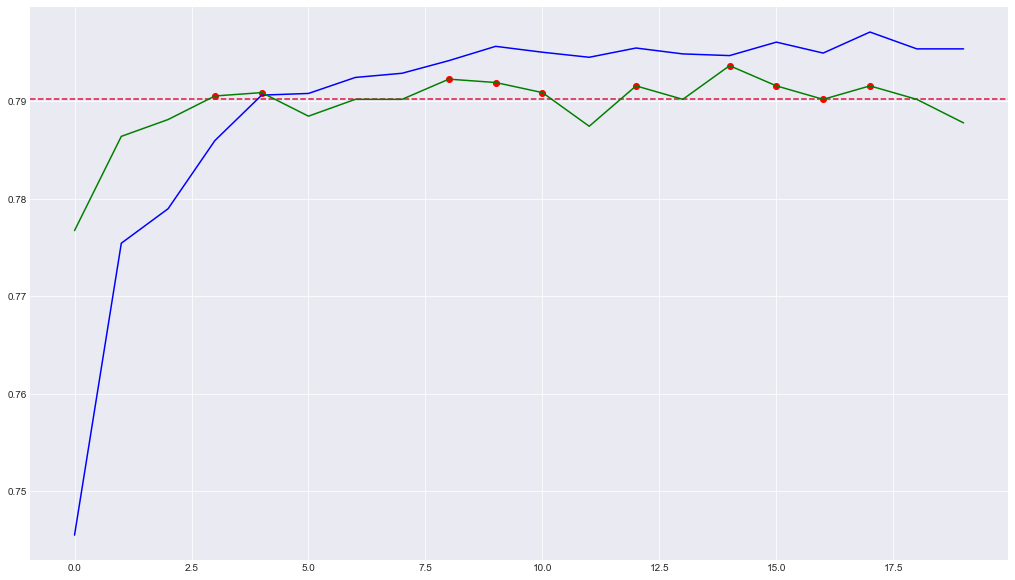

In [10]:
plt.figure(figsize=(14,8))
acc = np.array(history.history["accuracy"])
val_acc = np.array(history.history["val_accuracy"])
asdf = np.argsort(val_acc)[-10:]
plt.axhline(y=val_acc[asdf[0]], c="crimson", ls="--")
plt.plot(acc, c="b")
plt.plot(val_acc, c="g")
plt.scatter(asdf, val_acc[asdf], c="r")